In [1]:
import pycodestyle
import flake8
%load_ext pycodestyle_magic

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import cv2
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [ ]:
# https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
# model_article = hub.load('http://dl.caffe.berkeleyvision.org/finetune_flickr_style.caffemodel')

# Preprocess Image and Load

In [25]:
def load_image(img_path: str):
    max_dim = 512
    img = tf.io.read_file(img_path)
    # Make sure that the imagem have 3 channels
    img = tf.image.decode_image(img, channels=3)
    # Convert image
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]

    return img

5:5: E265 block comment should start with '# '
18:1: W391 blank line at end of file


In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [26]:
%%pycodestyle
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

3:3: E111 indentation is not a multiple of 4
4:3: E111 indentation is not a multiple of 4
5:3: E111 indentation is not a multiple of 4
5:21: E225 missing whitespace around operator
8:3: E111 indentation is not a multiple of 4
9:1: W391 blank line at end of file


In [ ]:
# content_image = load_image('images/turminha.jpg')
content_image = load_image('Projeto/images/Tuebingen_Neckarfront.jpg')

style_image = load_image('Projeto/images/William-Turner-Shipwreck.jpg')

In [ ]:
dir(content_image)
content_image.shape

TensorShape([1, 384, 512, 3])

## Visualize Output

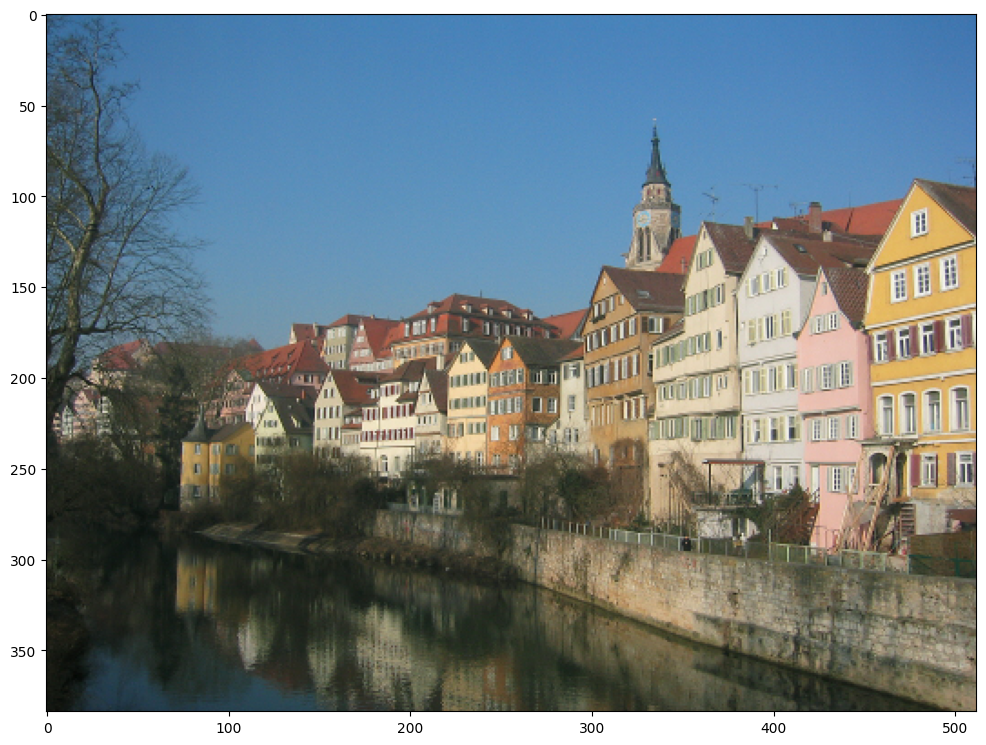

In [ ]:
imshow(content_image)

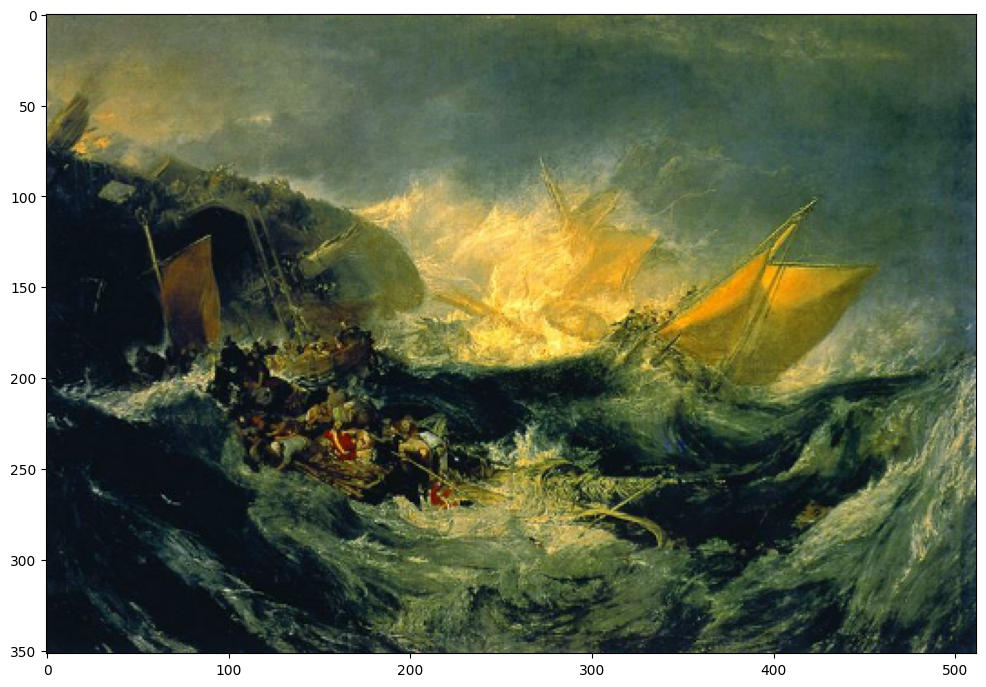

In [ ]:
imshow(style_image)

# Using model

In [ ]:
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0]

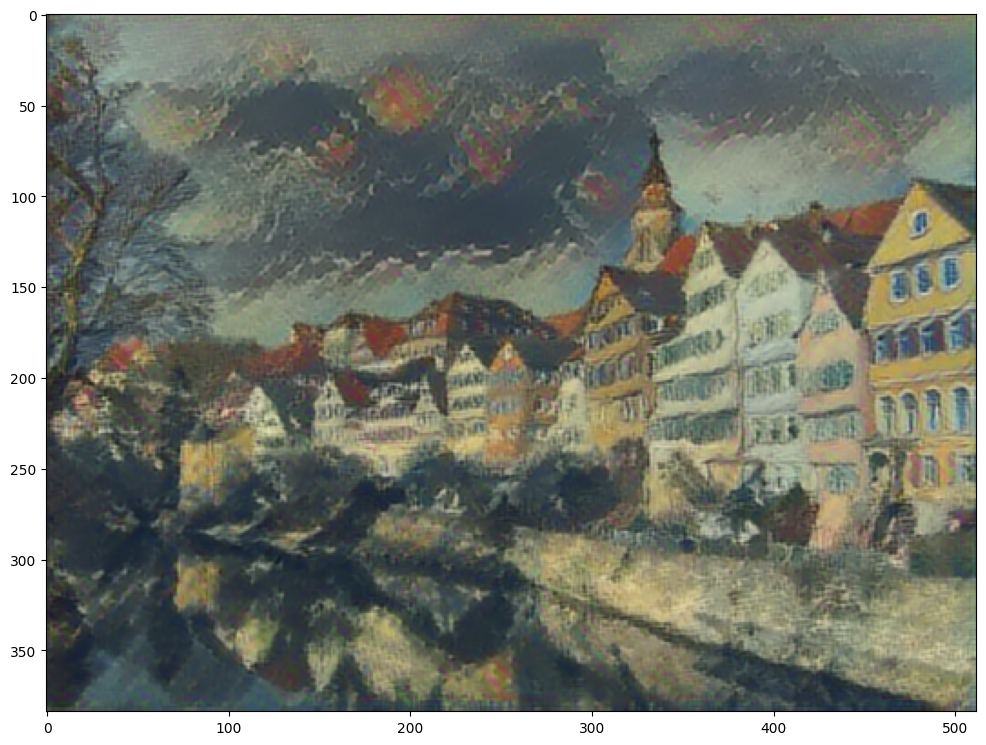

In [ ]:
plt.imshow(np.squeeze(stylized_image))
plt.show()

In [27]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

7:1: W391 blank line at end of file


In [28]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

6:3: E111 indentation is not a multiple of 4
7:1: W391 blank line at end of file


In [30]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

12:1: W391 blank line at end of file


In [33]:
def vgg_layers(layer_names):
    """
    Creates a VGG model that returns a list of intermediate output values.
    """
    # Load our model. Load pretrained VGG, trained on ImageNet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
  return model

3:8: W291 trailing whitespace


ValueError: too many values to unpack (expected 3)

In [35]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

13:1: W391 blank line at end of file


In [37]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

7:1: W391 blank line at end of file


In [ ]:
class StyleContentModel(tf.keras.models.Model):

    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


In [39]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

22:1: W391 blank line at end of file


In [3]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

4:1: W391 blank line at end of file


In [4]:
image = tf.Variable(content_image)

3:1: W391 blank line at end of file


In [5]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

3:3: E111 indentation is not a multiple of 4
4:1: W391 blank line at end of file


In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

3:1: W391 blank line at end of file


In [7]:
style_weight = 1e-2
content_weight = 1e4

4:1: W391 blank line at end of file


In [12]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] -
                                           style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] -
                                             content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

16:1: W391 blank line at end of file


In [15]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
    loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

11:1: W391 blank line at end of file


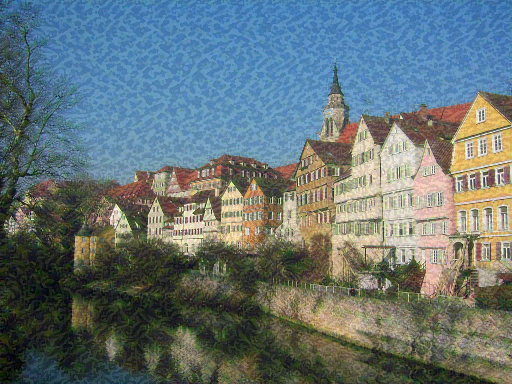

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [17]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

ValueError: too many values to unpack (expected 3)

In [18]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

18:1: W391 blank line at end of file


In [19]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

9:1: W391 blank line at end of file


In [ ]:
total_variation_weight = 30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

4:1: W391 blank line at end of file


In [24]:
import time
start = time.time()

epochs = 100
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 13)